In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")  # Suprime avisos

In [57]:
def plot_unfiltered(path,name, color,ax):
    # Carrega o CSV; substitua 'seuarquivo.csv' pelo caminho do seu arquivo
    df = pd.read_csv(path, parse_dates=['Post Timestamp', 'Reply Timestamp'])

    df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]


    unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])

    # Gera uma nova coluna com o início do mês para cada post
    unique_posts['Start of Month'] = unique_posts['Post Timestamp'].dt.to_period('M').apply(lambda r: r.start_time)

    # Conta quantos posts únicos por mês
    monthly_counts = unique_posts.groupby('Start of Month').size()

    # Cria o line plot
    ax.plot(monthly_counts.index, monthly_counts.values,label = name,color = color)
    return None


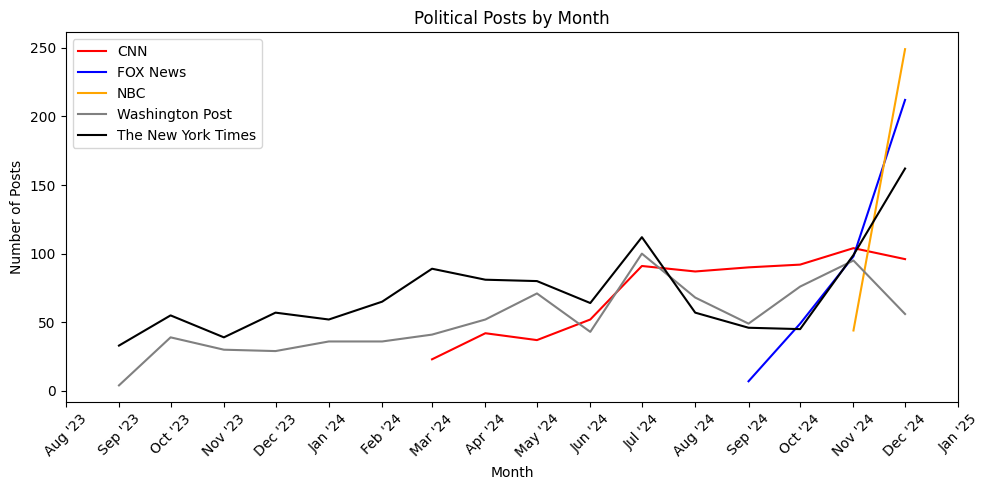

In [58]:

fig, ax = plt.subplots(figsize=(10,5))

plot_unfiltered("politics_posts_and_replies_CNN.csv", "CNN","red",ax)
plot_unfiltered("politics_posts_and_replies_FOX.csv", "FOX News","blue",ax)
plot_unfiltered("politics_posts_and_replies_NBC.csv", "NBC","orange",ax)
plot_unfiltered("politics_posts_and_replies_TWP.csv", "Washington Post","gray",ax)
plot_unfiltered("politics_posts_and_replies_TNYT.csv", "The New York Times","black",ax)





ax.set_title('Political Posts by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Posts')

all_months = pd.date_range(start='2023-08-01', end="2025-01-01", freq='MS')

ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)


plt.legend(loc= "best")

plt.tight_layout()
plt.show()

In [47]:
def plot_overall_keyword_percentage_weekly_smoothed(paths, keyword, color, ax, window=4):
    all_frames = []
    # Loop por cada arquivo para ler, filtrar e preparar os dados
    for path in paths:
        df = pd.read_csv(path, parse_dates=['Post Timestamp', 'Reply Timestamp'])
        df = df[(df['Post Timestamp'] >= '2023-09-01') & (df['Post Timestamp'] <= '2025-01-01')]
        
        # Se for o dataset da FOX, substitui texto vazio pelo link
        if "FOX" in path:
            # Verifica onde 'Post Text' está vazio ou nulo e substitui pelo 'Post Link'
            df['Post Text'] = df["Post Link"].copy()
        
        # Remove duplicatas baseadas no post
        unique_posts = df.drop_duplicates(subset=['Post Text', 'Post Timestamp', 'Post Link'])
        unique_posts['Start of Week'] = unique_posts['Post Timestamp']\
                                        .dt.to_period('W')\
                                        .apply(lambda r: r.start_time)
        all_frames.append(unique_posts)

    # Combina dados de todos os datasets
    combined = pd.concat(all_frames, ignore_index=True)

    # Conta total de posts por semana
    total_weekly = combined.groupby('Start of Week').size()

    # Filtra posts que contêm a palavra-chave (case-insensitive)
    keyword_posts = combined[combined['Post Text'].str.contains(keyword, case=False, na=False)]
    keyword_weekly = keyword_posts.groupby('Start of Week').size()

    # Cria uma sequência de semanas completas no intervalo para reindexar
    all_weeks = pd.date_range(start='2023-09-01', end='2025-01-01', freq='W-MON')
    total_weekly = total_weekly.reindex(all_weeks, fill_value=0)
    keyword_weekly = keyword_weekly.reindex(all_weeks, fill_value=0)

    # Calcula a porcentagem semanal
    percentage = (keyword_weekly / total_weekly.replace(0, pd.NA)) * 100
    percentage = percentage.fillna(0)

    # Aplica suavização com média móvel
    smoothed = percentage.rolling(window=window, min_periods=1, center=True).mean()

    # Plota a linha suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{keyword}", color=color)


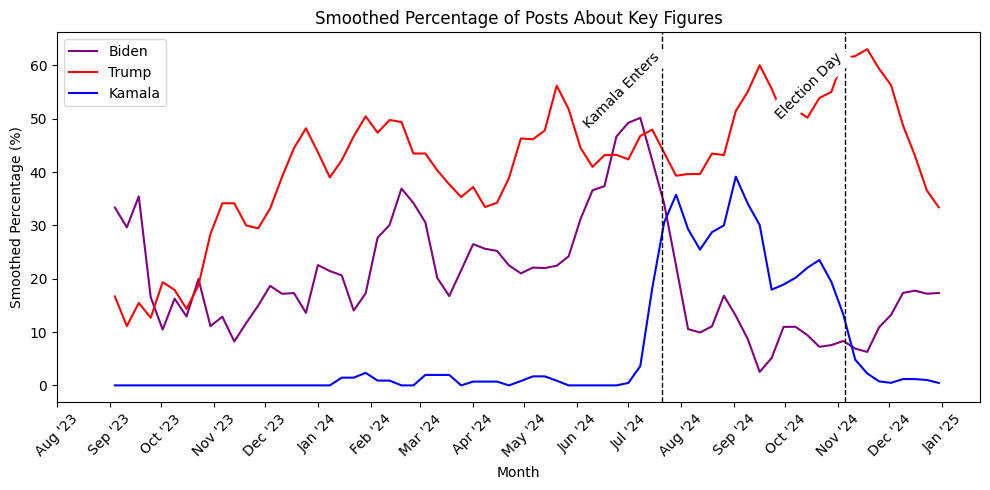

In [55]:
# Lista de caminhos para seus datasets
paths = [
    "politics_posts_and_replies_CNN.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv"
]

fig, ax = plt.subplots(figsize=(10,5))
w = 3
# Plota a porcentagem agregada suavizada semanalmente
plot_overall_keyword_percentage_weekly_smoothed(paths, "Biden", "purple", ax,window=w)
plot_overall_keyword_percentage_weekly_smoothed(paths, "Trump", "red", ax,window=w)
plot_overall_keyword_percentage_weekly_smoothed(paths, "Kamala", "blue", ax, window=w)


ax.set_title('Smoothed Percentage of Posts About Key Figures')
ax.set_xlabel('Month')
ax.set_ylabel('Smoothed Percentage (%)')


event_dates = {
    "Kamala Enters": "2024-07-21",
    "Election Day": "2024-11-05"
}

ymax = ax.get_ylim()[1]

for event, date_str in event_dates.items():
    event_date = pd.Timestamp(date_str)
    ax.axvline(event_date, color='black', linestyle='--', linewidth=1)
    ax.text(event_date, ymax * 0.95, event,
            rotation=45,
            verticalalignment='top',
            horizontalalignment='right',
            backgroundcolor='white')

# Define ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [100]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Baixa o léxico VADER na primeira vez
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

texts = [
    "I love this product!",
    "Shit",
    "The event was okay, nothing special."
]

for text in texts:
    scores = sia.polarity_scores(text)
    print(f"Texto: {text}")
    print(f"Pontuações de Sentimento: {scores}\n")


Texto: I love this product!
Pontuações de Sentimento: {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696}

Texto: Shit
Pontuações de Sentimento: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5574}

Texto: The event was okay, nothing special.
Pontuações de Sentimento: {'neg': 0.277, 'neu': 0.49, 'pos': 0.233, 'compound': -0.092}



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [71]:
def plot_average_reply_sentiment_weekly_keyword(paths, keyword, color, ax, window=4, lab = None):

    if lab == None:
        lab = keyword
    analyzer = SentimentIntensityAnalyzer()
    all_frames = []
    
    for path in paths:
        # Ler CSV e garantir que 'Reply Timestamp' é datetime
        df = pd.read_csv(path, parse_dates=['Reply Timestamp', 'Post Timestamp'])
        
        # Converter explicitamente para datetime e descartar linhas sem data válida
        df['Reply Timestamp'] = pd.to_datetime(df['Reply Timestamp'], errors='coerce')
        df = df.dropna(subset=['Reply Timestamp'])
        
        # Filtrar pelo intervalo de datas baseado em 'Reply Timestamp'
        df = df[(df['Reply Timestamp'] >= '2023-09-01') & (df['Reply Timestamp'] <= '2025-01-01')]
        
        # Se for dataset da FOX, substituir texto vazio pelo link
        if "FOX" in path:
            df['Post Text'] = df["Post Link"]
        
        # Filtrar linhas onde o post contém a palavra-chave (case-insensitive)
        keyword_mask = df['Post Text'].str.contains(keyword, case=False, na=False)
        df = df[keyword_mask]
        
        # Se não houver dados após filtrar, pular este arquivo
        if df.empty:
            continue

        # Calcular o sentimento composto de cada reply
        df['reply_compound'] = df['Reply Text'].apply(
            lambda text: analyzer.polarity_scores(text)['compound'] if pd.notnull(text) else None
        )
        df = df.dropna(subset=['reply_compound'])
        
        # Criar coluna com o início da semana baseado em 'Reply Timestamp'
        df['Start of Week'] = df['Reply Timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
        
        # Selecionar apenas as colunas necessárias para análise
        all_frames.append(df[['Start of Week', 'reply_compound']])
    
    # Verifica se há dados coletados
    if not all_frames:
        print("Nenhum dado disponível após filtragem.")
        return
    
    # Combinar dados de todos os arquivos
    combined = pd.concat(all_frames, ignore_index=True)
    
    # Calcular a média semanal do sentimento composto
    weekly_avg = combined.groupby('Start of Week')['reply_compound'].mean()
    
    # Aplicar média móvel para suavização
    smoothed = weekly_avg.rolling(window=window, min_periods=1, center=True).mean()
    
    # Plotar a série suavizada
    ax.plot(smoothed.index, smoothed.values, label=f"{lab}", color=color)

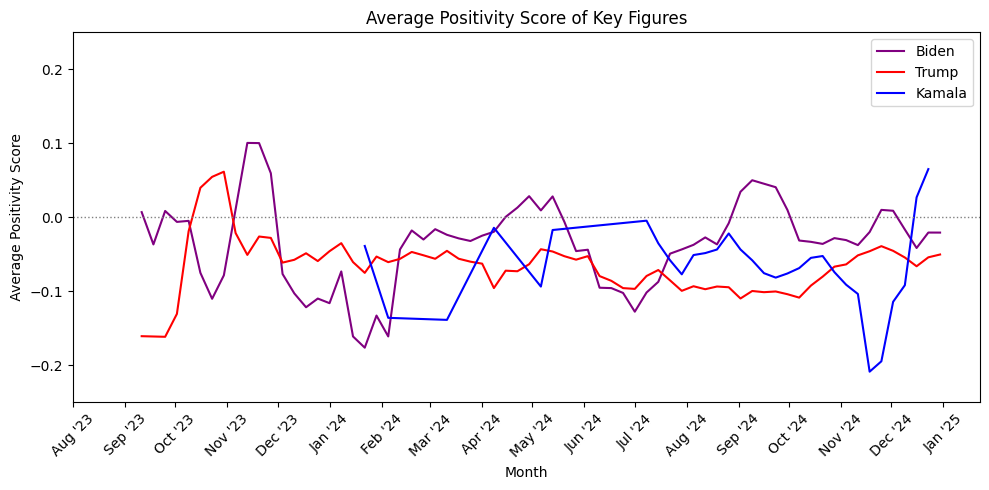

In [70]:
# Lista de caminhos para seus arquivos CSV
paths = [
    "politics_posts_and_replies_CNN.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv"
]

fig, ax = plt.subplots(figsize=(10,5))

# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(paths, "Biden", "purple", ax)
plot_average_reply_sentiment_weekly_keyword(paths, "Trump", "red", ax)
plot_average_reply_sentiment_weekly_keyword(paths, "Kamala", "blue", ax)

ax.set_title('Average Positivity Score of Key Figures')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.25, 0.25)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


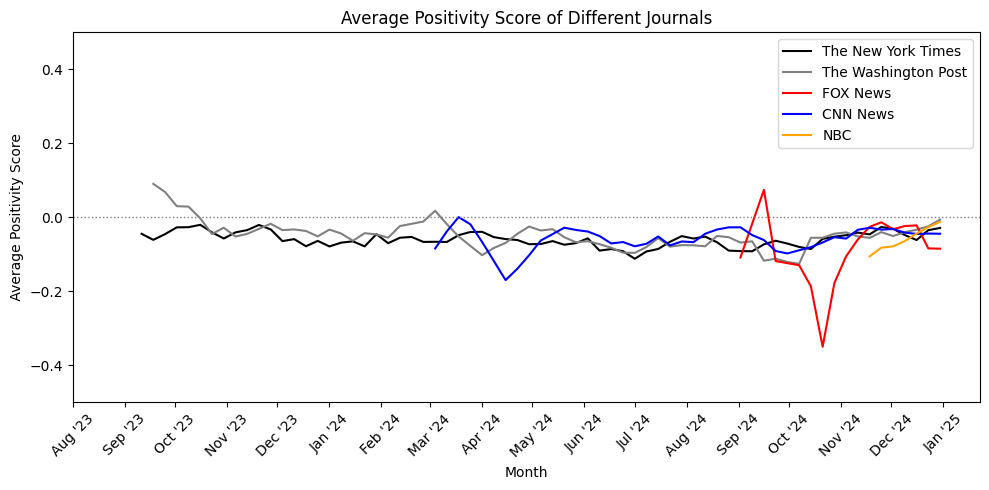

In [81]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))

# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], "", "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], "", "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], "", "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], "", "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], "", "orange", ax, lab="NBC")





ax.set_title('Average Positivity Score of Different Journals')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


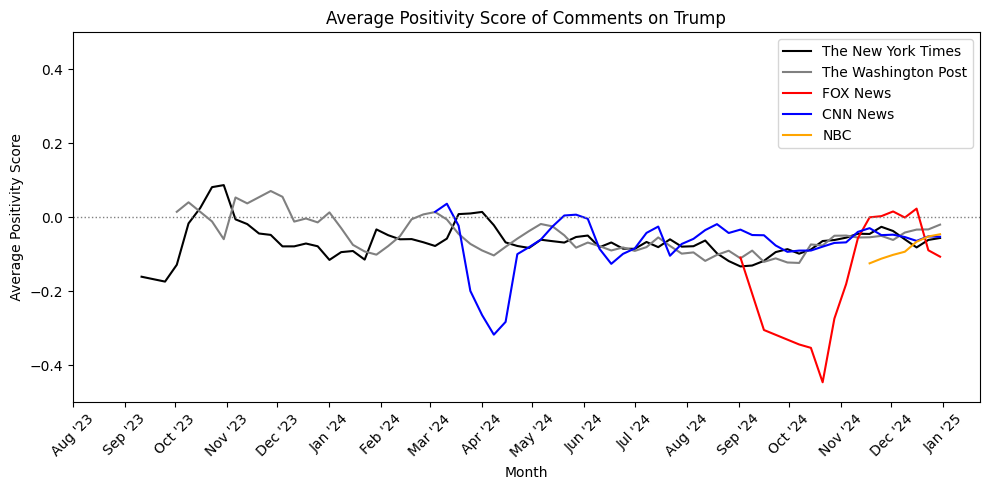

In [82]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Trump"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


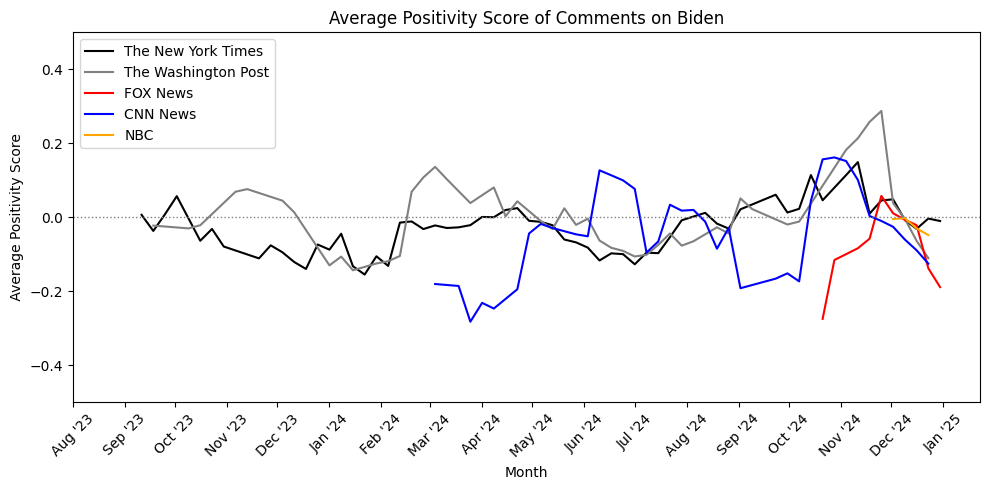

In [83]:
# Lista de caminhos para seus arquivos CSV

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Biden"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


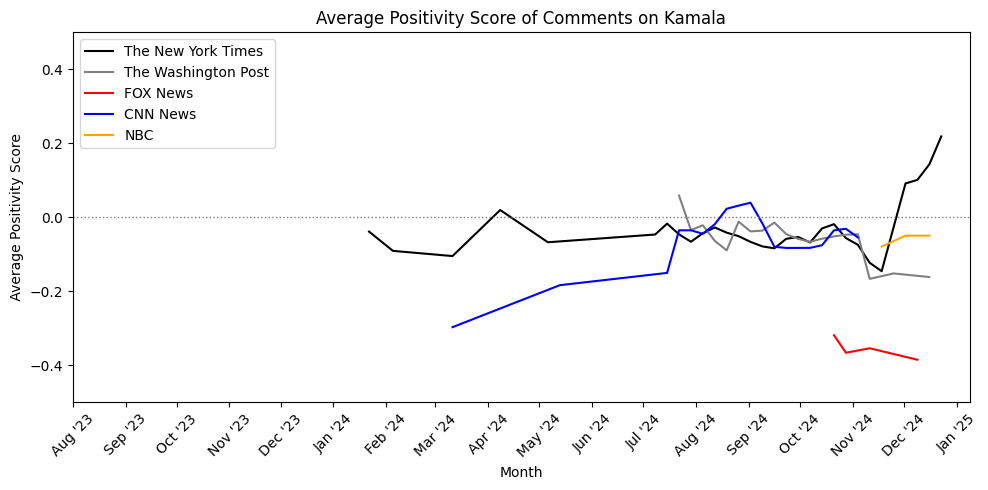

In [84]:
# Lista de caminhos para seus arquivos CSV

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Kamala"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


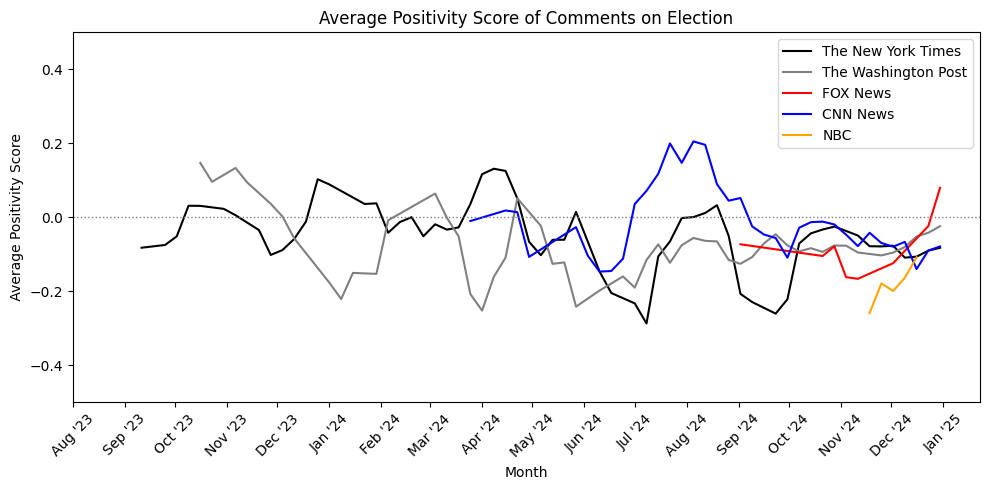

In [87]:
# Lista de caminhos para seus arquivos CSV
paths = ["politics_posts_and_replies_TNYT.csv"]

fig, ax = plt.subplots(figsize=(10,5))


keyword = "Election"
# Plotar o sentimento médio de replies para posts que contêm a palavra-chave
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TNYT.csv"], keyword, "black", ax, lab="The New York Times")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_TWP.csv"], keyword, "gray", ax, lab="The Washington Post")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_FOX.csv"], keyword, "red", ax, lab="FOX News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_CNN.csv"], keyword, "blue", ax, lab="CNN News")
plot_average_reply_sentiment_weekly_keyword(["politics_posts_and_replies_NBC.csv"], keyword, "orange", ax, lab="NBC")





ax.set_title(f'Average Positivity Score of Comments on {keyword}')
ax.set_xlabel('Month')
ax.set_ylabel(' Average Positivity Score ')

ax.axhline(0, color='gray', linestyle=':', linewidth=1)

# Define os limites do eixo y de -0,2 a 0,2
ax.set_ylim(-0.5, 0.5)

# Definir ticks mensais no eixo X
all_months = pd.date_range(start='2023-08-01', end='2025-01-01', freq='MS')
ax.set_xticks(all_months)
ax.set_xticklabels(all_months.strftime("%b '%y"), rotation=45)

plt.legend(loc="best")
plt.tight_layout()
plt.show()


1      0.125315
2      0.077762
3      0.062098
4      0.052867
5      0.053706
         ...   
258    0.000280
290    0.000280
294    0.000280
325    0.000280
376    0.000280
Name: proportion, Length: 192, dtype: float64


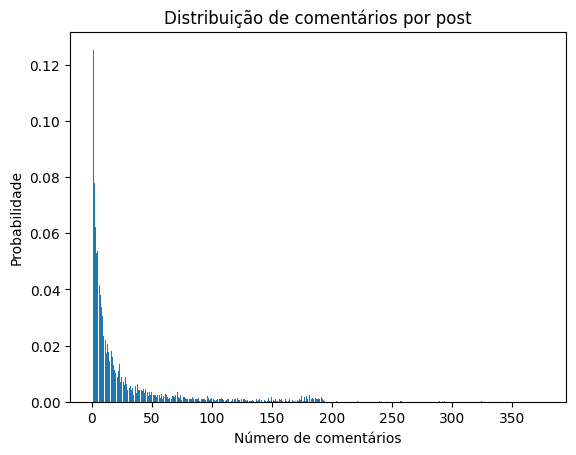

In [5]:

# Lista com os nomes dos arquivos CSV
arquivos = [
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_CNN.csv"
]

# Lê cada arquivo e armazena os DataFrames em uma lista
lista_dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

# Concatena todos os DataFrames em um único DataFrame
df_total = pd.concat(lista_dfs, ignore_index=True)

# Agrupa pelos posts (usando "Post Link" para identificar posts únicos) e conta quantos comentários cada um recebeu
comentarios_por_post = df_total.groupby("Post Link").size()

# Calcula a distribuição: probabilidade de ter x comentários
distribuicao = comentarios_por_post.value_counts(normalize=True).sort_index()

# Mostra a distribuição no console
print(distribuicao)

# Opcional: visualiza a distribuição em um gráfico de barras
plt.bar(distribuicao.index, distribuicao.values)
plt.xlabel("Número de comentários")
plt.ylabel("Probabilidade")
plt.title("Distribuição de comentários por post")

plt.show()


1      0.125315
2      0.203077
3      0.265175
4      0.318042
5      0.371748
         ...   
258    0.998881
290    0.999161
294    0.999441
325    0.999720
376    1.000000
Name: proportion, Length: 192, dtype: float64


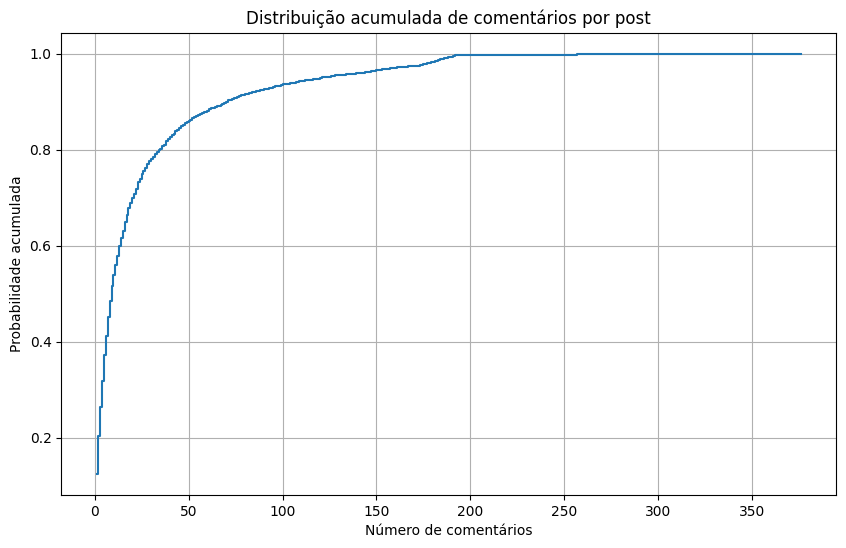

In [6]:
# Lista com os nomes dos arquivos CSV
arquivos = [
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_CNN.csv"
]

# Lê cada arquivo e armazena os DataFrames em uma lista
lista_dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

# Concatena todos os DataFrames em um único DataFrame
df_total = pd.concat(lista_dfs, ignore_index=True)

# Agrupa pelos posts usando "Post Link" para identificar posts únicos
comentarios_por_post = df_total.groupby("Post Link").size()

# Calcula a distribuição: probabilidade de ter x comentários
distribuicao = comentarios_por_post.value_counts(normalize=True).sort_index()

# Calcula a distribuição acumulada
distribuicao_acumulada = distribuicao.cumsum()

# Exibe a distribuição acumulada no console
print(distribuicao_acumulada)

# Plota a distribuição acumulada
plt.figure(figsize=(10,6))
plt.step(distribuicao_acumulada.index, distribuicao_acumulada.values, where='post')
plt.xlabel("Número de comentários")
plt.ylabel("Probabilidade acumulada")
plt.title("Distribuição acumulada de comentários por post")
plt.grid(True)
plt.show()

In [7]:
import pandas as pd

# Lista com os nomes dos arquivos CSV
arquivos = [
    "politics_posts_and_replies_TWP.csv",
    "politics_posts_and_replies_TNYT.csv",
    "politics_posts_and_replies_NBC.csv",
    "politics_posts_and_replies_FOX.csv",
    "politics_posts_and_replies_CNN.csv"
]

# Lê cada arquivo e armazena os DataFrames em uma lista
lista_dfs = [pd.read_csv(arquivo) for arquivo in arquivos]

# Concatena todos os DataFrames em um único DataFrame
df_total = pd.concat(lista_dfs, ignore_index=True)

# Agrupa pelos posts usando "Post Link" para identificar posts únicos e conta comentários
comentarios_por_post = df_total.groupby("Post Link").size()

# Identifica os posts com mais de 25 comentários
posts_com_mais_de_25 = comentarios_por_post[comentarios_por_post > 25].index

# Filtra o DataFrame para incluir somente os posts com mais de 25 comentários
df_filtrado = df_total[df_total["Post Link"].isin(posts_com_mais_de_25)]

# Salva os dados filtrados em um novo arquivo CSV
df_filtrado.to_csv("posts_com_mais_de_25_comentarios.csv", index=False)

print(f"Salvo {len(df_filtrado)} linhas no arquivo 'posts_com_mais_de_25_comentarios.csv'")


Salvo 69529 linhas no arquivo 'posts_com_mais_de_25_comentarios.csv'


In [8]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Inicializa o analisador de sentimentos
analyzer = SentimentIntensityAnalyzer()

# Carrega o dataset de posts com mais de 25 comentários
df = pd.read_csv("posts_com_mais_de_25_comentarios.csv", parse_dates=['Post Timestamp', 'Reply Timestamp'])

# Calcular o sentimento composto para cada reply
df['reply_compound'] = df['Reply Text'].apply(
    lambda text: analyzer.polarity_scores(text)['compound'] if pd.notnull(text) else None
)

# Remove comentários sem sentimento calculado
df = df.dropna(subset=['reply_compound'])

# Agrupar por post para calcular a média do sentimento dos comentários
agrupado = df.groupby("Post Link").agg({
    "Post Text": "first",             # Título do post
    "Post Timestamp": "first",        # Timestamp do post
    "reply_compound": "mean"          # Média do sentimento dos comentários
}).reset_index()

# Renomear a coluna para clareza
agrupado.rename(columns={"reply_compound": "average_sentiment"}, inplace=True)

# Ordenar pela negatividade (ou seja, pelos valores mais baixos de sentimento primeiro)
agrupado_sorted = agrupado.sort_values("average_sentiment")

# Selecionar colunas de interesse e salvar em um novo CSV
agrupado_sorted[["Post Text", "Post Timestamp", "Post Link", "average_sentiment"]] \
    .to_csv("average_sentiment_by_post.csv", index=False)

print("Arquivo 'average_sentiment_by_post.csv' criado com sucesso!")


Arquivo 'average_sentiment_by_post.csv' criado com sucesso!


In [20]:
import nltk

# Baixa os recursos necessários do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')  # Caso ainda não tenha baixado para análises de sentimento
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string

# Baixa os recursos necessários do NLTK (caso ainda não tenha sido feito)
nltk.download('punkt')
nltk.download('stopwords')

# Carrega o dataset com os posts filtrados
df = pd.read_csv("average_sentiment_by_post.csv")

# Combina todos os textos dos posts em uma única string
all_text = " ".join(df['Post Text'].astype(str).tolist())

# Tokeniza o texto
tokens = word_tokenize(all_text)

# Define a lista de stopwords em inglês padrão
stop_words = set(stopwords.words('english'))

# Define uma lista de stopwords personalizadas
additional_stopwords = {
    'would', 'said', 'say', 'says', 'also', 'could', 'get', 'got',
    'like', 'might', 'must', 'need', 'one', 'said', 'see', 'said',
    'should', 'still', 'take', 'took', 'tell', 'tells', 'tell',
    'think', 'thinks', 'used', 'use', 'using', 'way', 'ways',
    'work', 'worked', 'working', 'works'
}

# Combina as stopwords padrão com as personalizadas
stop_words = stop_words.union(additional_stopwords)

# Filtra tokens: remove pontuação, stopwords, e palavras com 2 ou menos caracteres
filtered_words = [
    word.lower() for word in tokens 
    if word.isalpha() and word.lower() not in stop_words and len(word) > 2
]

# Conta a frequência das palavras
word_counts = Counter(filtered_words)

# Exibe as 20 palavras mais comuns
most_common_words = word_counts.most_common(20)
print("As 20 palavras mais comuns são:")
for word, count in most_common_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As 20 palavras mais comuns são:
trump: 652
donald: 370
president: 266
biden: 190
news: 129
house: 119
former: 114
new: 113
breaking: 93
election: 84
campaign: 69
harris: 67
presidential: 64
first: 62
office: 62
court: 60
administration: 56
kamala: 54
white: 54
people: 52


In [7]:
from nltk.stem import WordNetLemmatizer

# Baixa o recurso necessário para lematização
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Aplica a lematização
filtered_words = [
    lemmatizer.lemmatize(word.lower()) for word in tokens 
    if word.isalpha() and word.lower() not in stop_words and len(word) > 2
]

# Conta a frequência das palavras
word_counts = Counter(filtered_words)

print(len(word_counts))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


4129


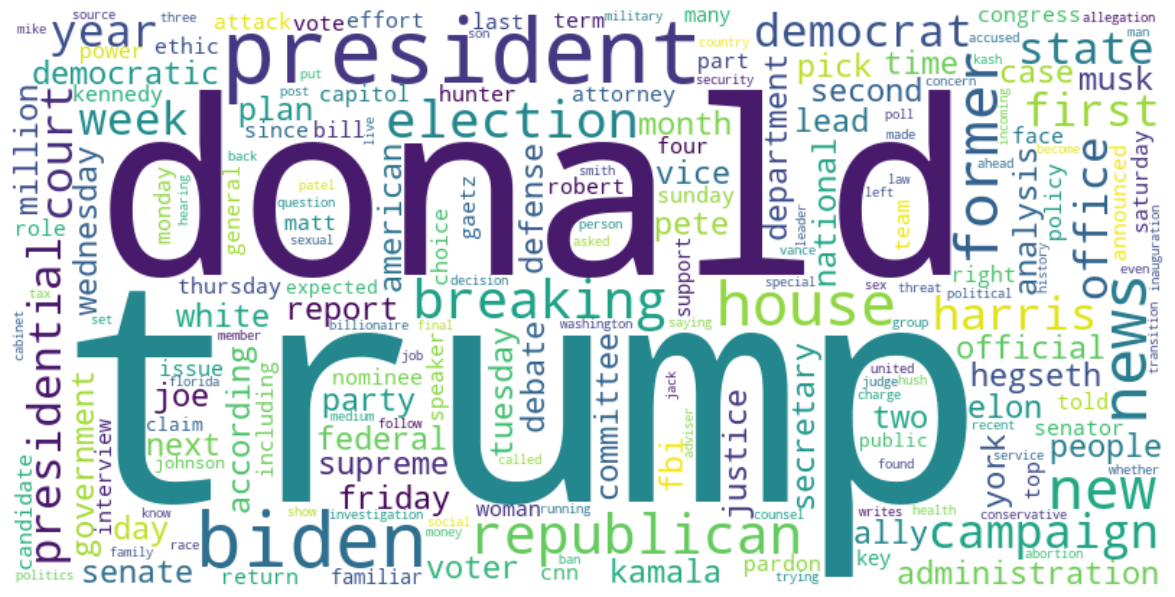

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gera a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)


# Exibe a nuvem de palavras
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()




ValueError: operands could not be broadcast together with shapes (1090,900,4) (1090,900,3) 

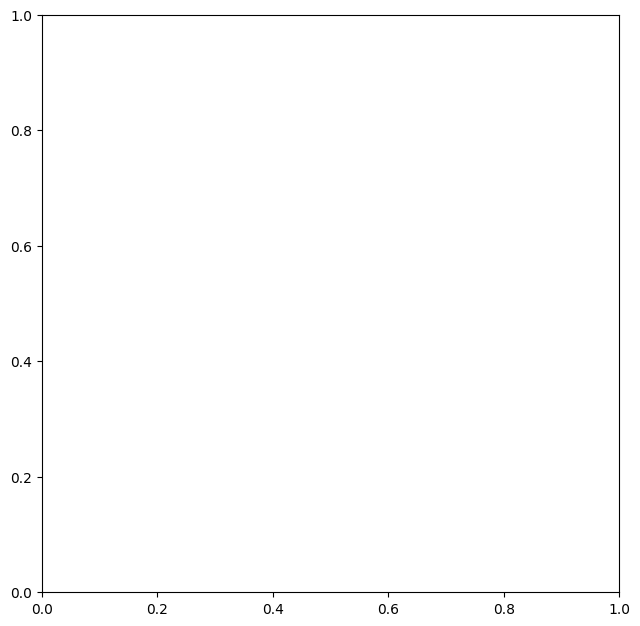

In [17]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Load your mask PNG (should be RGBA if you want transparency)
mask_image = np.array(Image.open('trump.png'))

# 2. Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400,
    mode='RGBA',                  # Use RGBA if you want to keep transparency
    background_color=None,        # Set background to None to keep it transparent
    mask=mask_image,              # Apply the mask
    contour_width=3,             # Optional: add a border around the text shape
    contour_color='black'        # Optional: border color
).generate_from_frequencies(word_counts)

# 3. Display the generated image
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
